In [143]:
# Import the libraries we need to do linear algebra
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib
import matplotlib.pyplot as plt
import copy
%matplotlib inline

# Functions & Classes

In [144]:
def increment_matrix(matrix: np.array, posn=(0,0), incr=0.01):
    """
    Increment the value of one position in a matrix by a given amount.
    Requires the argument matrix to have type np.array
    """
    new_matrix = copy.copy(matrix) 
    new_matrix[posn] += incr
    return new_matrix

def l1_normalize_matrix(matrix, magnitude=2.0):
    """
    Normalize matrix so the sum of elements equals magnitude (the L1 norm)
    """
    return magnitude*matrix/np.sum(matrix)

def reweight_nonneg_matrix(matrix: np.array,
                   posns = [(0,0), (1,1)],
                   frctn_delta = 0.01):
    """
    Modify a non-negative matrix while prerserving its magnitude (sum of elements).
    In other words, shift weight from some elements to others.
    """
    if np.any(matrix<0):
        raise ValueError("Matrix cannot have negative elements.")
    magnitude = np.sum(matrix)
    mask = np.zeros(matrix.shape, dtype=bool)
    for p in posns:
        mask[p] = True
    posns_delta = magnitude*frctn_delta/np.sum(mask)
    non_posns_delta = -magnitude*frctn_delta/np.sum(np.invert(mask))
    new_matrix = copy.copy(matrix)
    new_matrix[mask] += posns_delta
    new_matrix[np.invert(mask)] += non_posns_delta
    if np.any(new_matrix<0):
        raise ValueError("Delta is too large to produce a non-negative matrix.")    
    return(new_matrix)

def reweight_nonpos_matrix(matrix: np.array, **kwargs):
    """
    Modify a non-positive matrix while prerserving its magnitude (sum of elements).
    In other words, shift weight from some elements to others.
    """
    return(-reweight_nonneg_matrix(-matrix, **kwargs))


def increment_eigenvalues(base_matrix, **kwargs):
    """
    Add the amount increment to the top left element of base_matrix and return the eigenvalues/eigenvectors
    """
    new_matrix = increment_matrix(base_matrix, **kwargs)
    return np.linalg.eig(new_matrix)

def reweight_eigenvalues(base_matrix, neg=False, incl_matrix=False, **kwargs):
    """
    Add the amount increment to the top left element of base_matrix and return the eigenvalues/eigenvectors
    """
    if neg==False:
        new_matrix = reweight_nonneg_matrix(base_matrix, **kwargs)
    else:
        new_matrix = reweight_nonpos_matrix(base_matrix, **kwargs)
    eigen_results = list(np.linalg.eig(new_matrix))
    if incl_matrix:
        return(eigen_results + [new_matrix])
    else:
        return(eigen_results)
    
def matrix_interpolations(start_matrix, end_matrix, n_steps=50, normalize=False):
    """
    Generate a list of matrices that are linear interpolations between a start and end matrix (inclusive).
    :param normalize: If true then normalize all matrices to have same L1 norm (magnitude) as start_matrix
    """
    weights = list(np.arange(0,1,1/n_steps)) + [1]
    matrix_list = [(1-w)*start_matrix + w*end_matrix for w in weights]
    if normalize==True:
        magnitude = np.sum(np.abs(start_matrix))
        matrix_list = [m/np.sum(np.abs(m))*magnitude for m in matrix_list]
    return(matrix_list)

In [145]:
ff = [1,4,0]
gg = [1,2,3]
gg.sort()#key=ff)
print(ff)


s = sorted(zip(ff, gg))

[1, 4, 0]


In [147]:
a,b = map(list, zip(*s))
print(a)
print(b)

[0, 1, 4]
[3, 1, 2]


In [259]:
class EigenPath():
    """
    Compute eigenvectors and eigenvalues over a list of matrices (presumably following some path)
    """
    def __init__(self, matrix_list, drop_identity=True):
        """
        :param drop_identity: If True, drop any elements of list that are I.
        Generally desired b/c I is singular and all vectors are eigenvectors.
        """
        self.matrix_list = matrix_list
        if drop_identity:
            self.matrix_list = [x for x in self.matrix_list if not np.all(x == np.identity(2))]       

    def compute_eigen(self):
        """
        Compute eigenvalues and eigenvectors over matrix_list
        """
        eigen_path = [np.linalg.eig(matrix) for matrix in self.matrix_list]
        
        eigen_lists = [ (list(x[0]),
                         list(x[1].T)
                        ) for x in eigen_path]
        eigen_lists = [sorted(zip(x[0], x[1]), key=lambda y: y[0], reverse=True) for x in eigen_lists]

        eigenvalues = [
            [eigen_pair[0] for eigen_pair in matrix_values]
            for matrix_values in eigen_lists]
        eigenvectors = [
            [eigen_pair[1] for eigen_pair in matrix_values]
            for matrix_values in eigen_lists]
        

        def flip_negative_vectors(vector_list):
            """
            Iterate over a list of vectors and flip sign iff first element is negative.
            """
            return( [(vec if vec[0]>0 else -vec) for vec in vector_list] )
        
        eigenvectors = [flip_negative_vectors(vector_pair) for vector_pair in eigenvectors]
        
#         eigen_path = sorted(eigen_path, reverse=True) # Sort so the larger eigenvalue is always first.
#         eigenvalues = [x[0] for x in eigen_path]
#         eigenvectors = [x[1] for x in eigen_path]
 
        #eigenvalues = [np.sort(x)[::-1] for x in eigenvalues] # Sort so the larger eigenvalue is always first.
        eigen_df = pd.DataFrame(eigenvalues, columns=['eigenvalue_1', 'eigenvalue_2'])
        eigen_df.reset_index(inplace=True)
        eigen_df['index'] = eigen_df['index']/max(eigen_df['index'])
 
    
        def create_eigenvec_df(i):
            #eigenvec_df = [x[:,i] for x in eigenvectors]
            eigenvec_df = [x[i] for x in eigenvectors]
            # If eigenvector has a negative x value then flip the direction for consistency
            #eigenvec_df = [(x if x[0]>=0 else -x) for x in eigenvec_df] 
            eigenvec_df = pd.DataFrame(eigenvec_df, columns = ['eigenvec_x', 'eigenvec_y'])
            eigenvec_df.reset_index(inplace=True)
            eigenvec_df['index'] = eigenvec_df['index']/max(eigenvec_df['index'])
            if not np.iscomplexobj(eigenvec_df):
                eigenvec_df['angle'] = eigenvec_df.apply(lambda row: np.angle(row.eigenvec_x + row.eigenvec_y*1j, deg=True), axis=1)
            return(eigenvec_df)

        self.eigen_df = eigen_df
        self.eigenvec_1 = create_eigenvec_df(0)
        self.eigenvec_2 = create_eigenvec_df(1)
        #self.eigenvectors = [x[1] for x in eigen_path]
        
    def plot_eigenvals(self):
        """
        Plot eigenvalue trajectories.
        """
        if(np.iscomplexobj(self.eigen_df['eigenvalue_1']) or
           np.iscomplexobj(self.eigen_df['eigenvalue_2'])
          ):
            print('Some eigenvalues are complex.')
            plt.figure()
            X = [x.real for x in self.eigen_df['eigenvalue_1']]
            Y = [x.imag for x in self.eigen_df['eigenvalue_1']]
            plt.scatter(X,Y)
            plt.title("Eigenvalue 1")
            plt.xlabel("Real component")
            plt.ylabel("Imaginary component")
            plt.show()
            plt.figure()
            X = [x.real for x in self.eigen_df['eigenvalue_2']]
            Y = [x.imag for x in self.eigen_df['eigenvalue_2']]
            plt.scatter(X,Y)
            plt.title("Eigenvalue 2")
            plt.xlabel("Real component")
            plt.ylabel("Imaginary component")
            plt.show() 
            plt.figure()
            sns.scatterplot(x="eigenvalue_1", y="eigenvalue_2", data=self.eigen_df) 
            plt.title("Real components of eigenvalues 1 & 2")              
        else:
            print('All eigenvalues are real')
            plt.figure()
            sns.scatterplot(x="index", y="eigenvalue_1", data=self.eigen_df)
            plt.figure()
            sns.scatterplot(x="index", y="eigenvalue_2", data=self.eigen_df)
            plt.figure()
            sns.scatterplot(x="eigenvalue_1", y="eigenvalue_2", data=self.eigen_df)

    def plot_eigenvecs(self):
        if np.iscomplexobj(self.eigenvec_1):
            print('First eigenvector is complex, not plotting.')
        else:
            plt.figure()
            plt.axes().set_aspect('equal')
            plt.xlim(-1.1, 1.1)
            plt.ylim(-1.1, 1.1)
            sns.scatterplot(x="eigenvec_x", y="eigenvec_y", hue='index', legend=False, data=self.eigenvec_1)
            plt.figure()
            sns.scatterplot(x="index", y="angle", legend=False, data=self.eigenvec_1)

        if np.iscomplexobj(self.eigenvec_2):
            print('Second eigenvector is complex, not plotting.')
        else:
            plt.figure()
            plt.axes().set_aspect('equal')
            plt.xlim(-1.1, 1.1)
            plt.ylim(-1.1, 1.1)
            sns.scatterplot(x="eigenvec_x", y="eigenvec_y", hue='index', legend=False, data=self.eigenvec_2)            
            plt.figure()
            sns.scatterplot(x="index", y="angle", legend=False, data=self.eigenvec_2)            

# Eigenvalue/Eigenvector Path Plots
Note: Remember that 0.707107 is 1/sqrt(2). This value shows up often in normalized vectors.

All eigenvalues are real


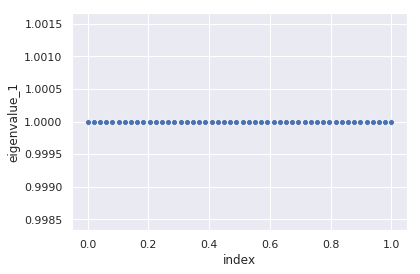

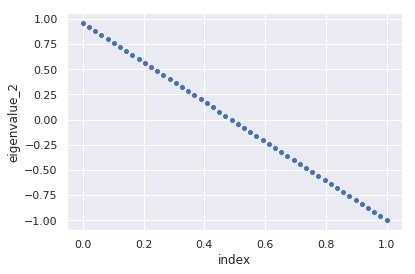

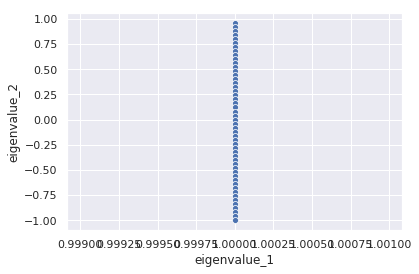

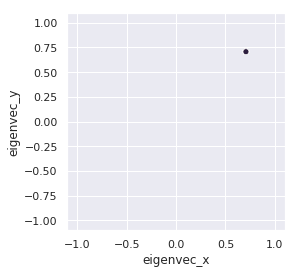

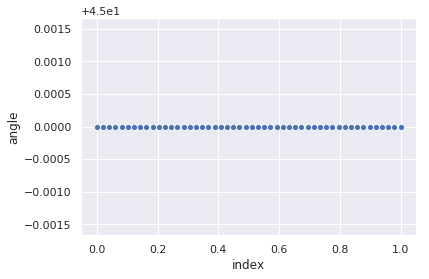

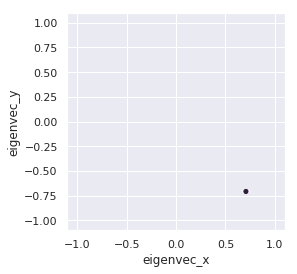

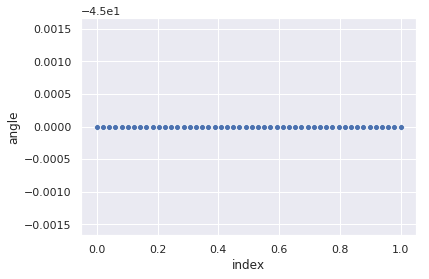

In [260]:
# Identity matrix to off-diagonal 1's.
base_matrix = np.identity(2)
deltas = np.arange(0, -1.01, -0.02)
matrix_path = [reweight_nonneg_matrix(base_matrix, frctn_delta=delta) for delta in deltas]

eigen_path = EigenPath(matrix_path)
eigen_path.compute_eigen()
eigen_path.plot_eigenvals()
eigen_path.plot_eigenvecs()

All eigenvalues are real


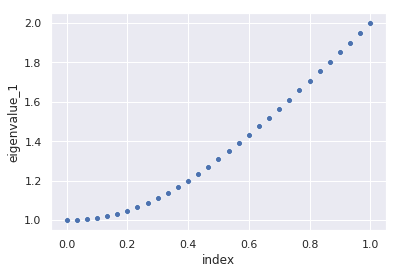

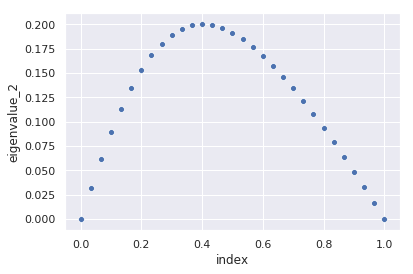

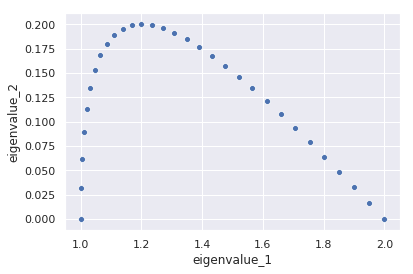

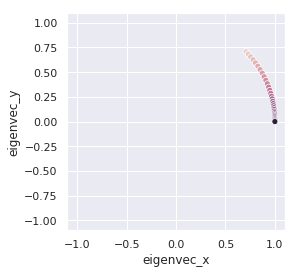

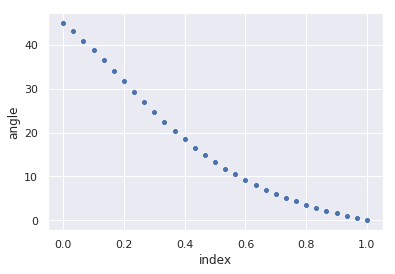

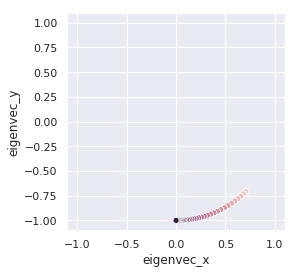

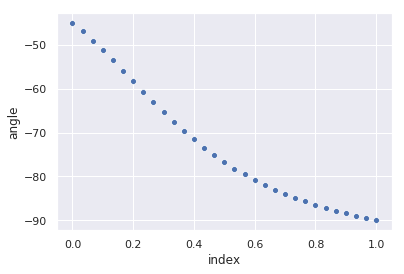

In [261]:
# Matrix path from uniform matrix to all weight on one diagonal element
base_matrix = np.ones((2, 2))
base_matrix = l1_normalize_matrix(base_matrix)
deltas = np.arange(0, 0.75001, 0.025)
matrix_path = [reweight_nonneg_matrix(base_matrix, frctn_delta=delta, posns=[(0,0)]) for delta in deltas]

eigen_path = EigenPath(matrix_path)
eigen_path.compute_eigen()
eigen_path.plot_eigenvals()
eigen_path.plot_eigenvecs()

All eigenvalues are real


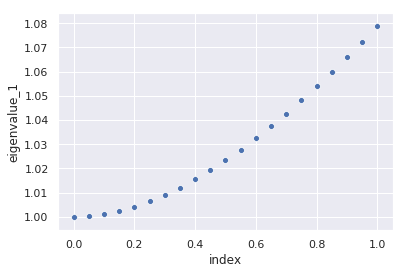

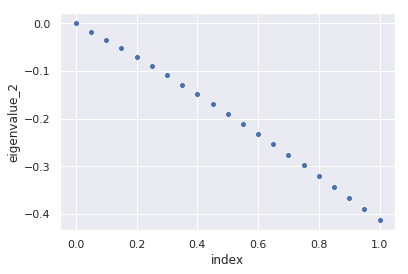

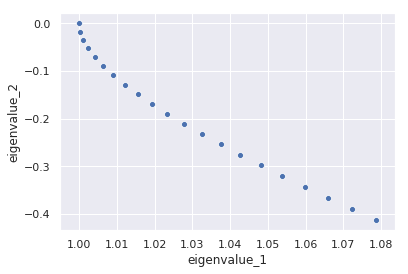

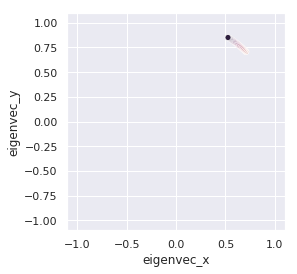

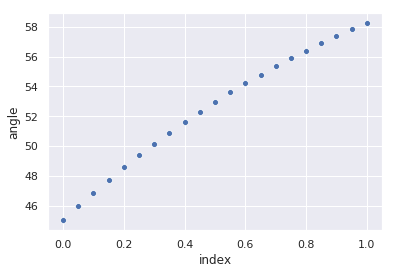

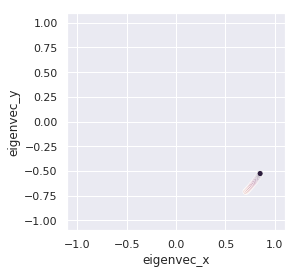

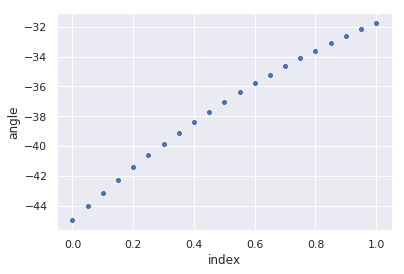

In [263]:
# Matrix path from uniform matrix to no weight on one diagonal element
base_matrix = np.ones((2, 2))
base_matrix = l1_normalize_matrix(base_matrix)

deltas = np.arange(0, -0.2501, -0.0125)
matrix_path = [reweight_nonneg_matrix(base_matrix, frctn_delta=delta, posns=[(0,0)]) for delta in deltas]

eigen_path = EigenPath(matrix_path)
eigen_path.compute_eigen()
eigen_path.plot_eigenvals()
eigen_path.plot_eigenvecs()

All eigenvalues are real


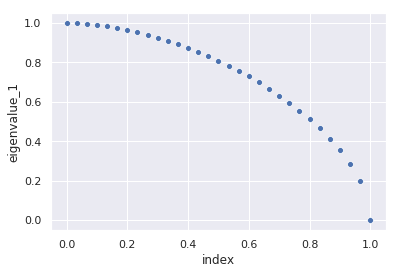

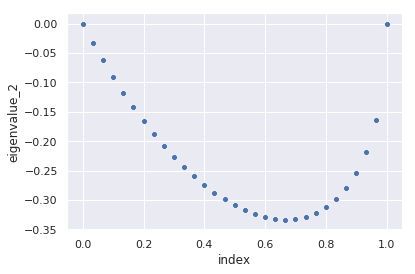

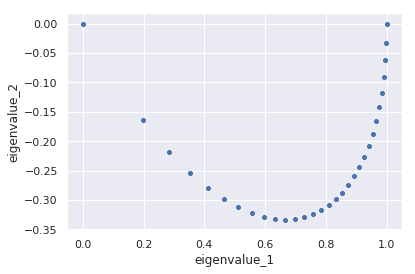

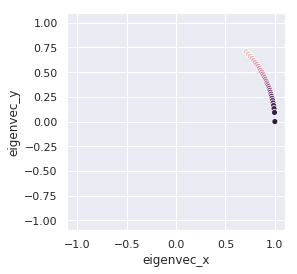

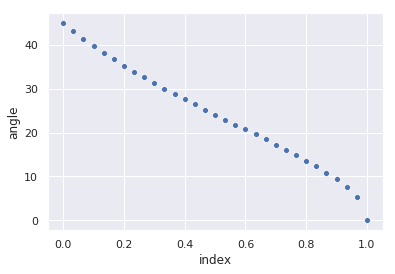

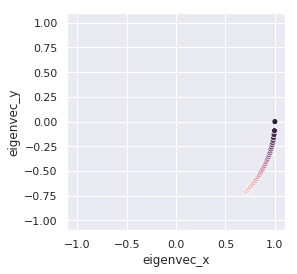

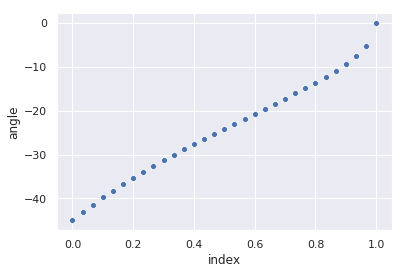

In [264]:
# Matrix path from uniform matrix to all weight on off-diagonal element
base_matrix = np.ones((2, 2))
base_matrix = l1_normalize_matrix(base_matrix)

deltas = np.arange(0, 0.75001, 0.025)
matrix_path = [reweight_nonneg_matrix(base_matrix, frctn_delta=delta, posns=[(0,1)]) for delta in deltas]

eigen_path = EigenPath(matrix_path)
eigen_path.compute_eigen()
eigen_path.plot_eigenvals()
eigen_path.plot_eigenvecs()

All eigenvalues are real


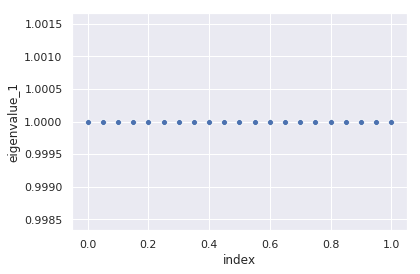

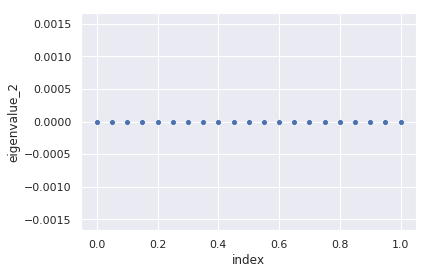

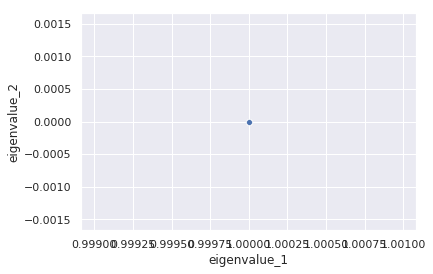

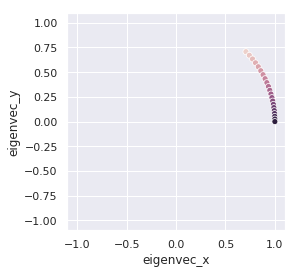

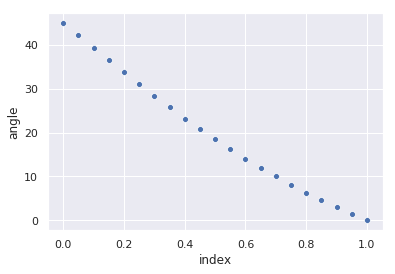

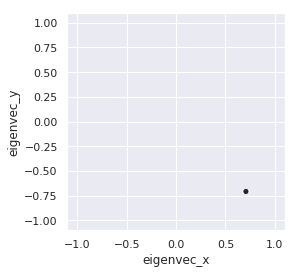

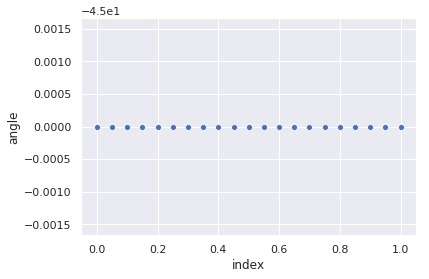

In [265]:
# Matrix path from uniform matrix to all weight on first row
base_matrix = np.ones((2, 2))
base_matrix = l1_normalize_matrix(base_matrix)

deltas = np.arange(0, 0.50001, 0.025)
matrix_path = [reweight_nonneg_matrix(base_matrix, frctn_delta=delta, posns=[(0,0), (0,1)]) for delta in deltas]

eigen_path = EigenPath(matrix_path)
eigen_path.compute_eigen()
eigen_path.plot_eigenvals()
eigen_path.plot_eigenvecs()

All eigenvalues are real


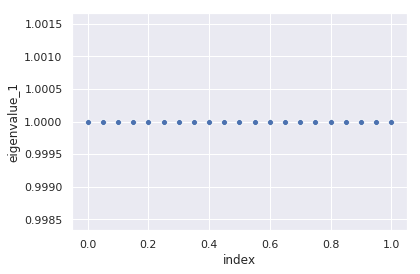

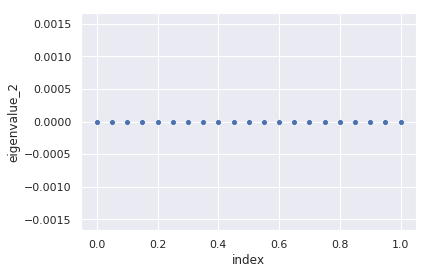

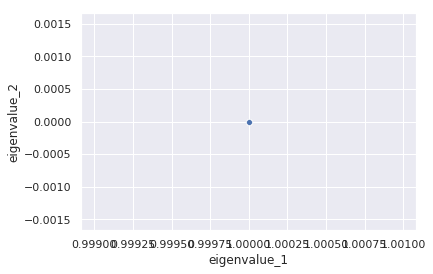

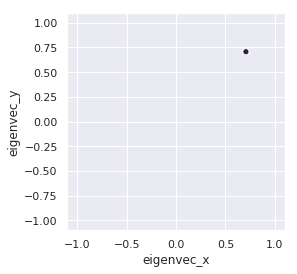

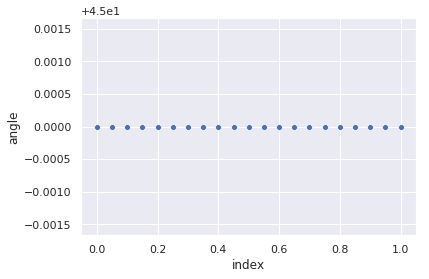

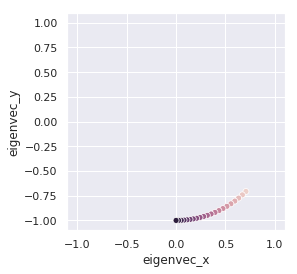

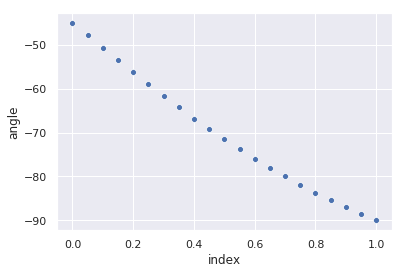

In [266]:
# Matrix path from uniform matrix to all weight on first column
base_matrix = np.ones((2, 2))
base_matrix = l1_normalize_matrix(base_matrix)

deltas = np.arange(0, 0.50001, 0.025)
matrix_path = [reweight_nonneg_matrix(base_matrix, frctn_delta=delta, posns=[(0, 0), (1, 0)]) for delta in deltas]

eigen_path = EigenPath(matrix_path)
eigen_path.compute_eigen()
eigen_path.plot_eigenvals()
eigen_path.plot_eigenvecs()

Some eigenvalues are complex.


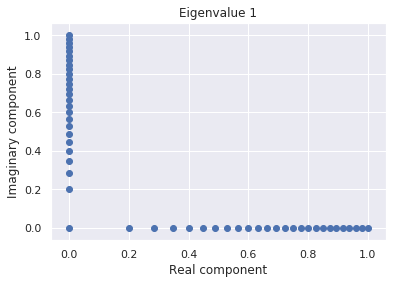

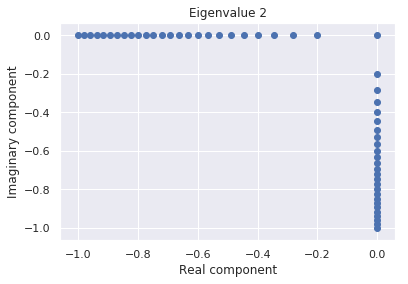

First eigenvector is complex, not plotting.
Second eigenvector is complex, not plotting.


/Users/kurtsmith/.pyenv/versions/3.6.6/envs/py3.6/lib/python3.6/site-packages/numpy/core/numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


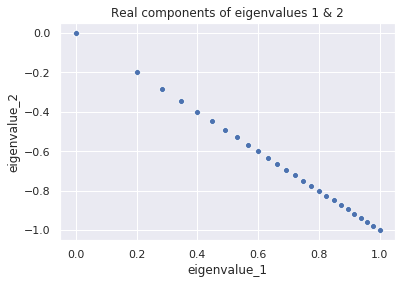

In [267]:
# Matrix path from opposite-signs diagonal to opposite-signs off-diagonal
matrices = matrix_interpolations(
    np.array([[1,0], [0,-1]]),
    np.array([[0,1], [-1, 0]])
)

eigen_path = EigenPath(matrices)
eigen_path.compute_eigen()
eigen_path.plot_eigenvals()
eigen_path.plot_eigenvecs()

All eigenvalues are real


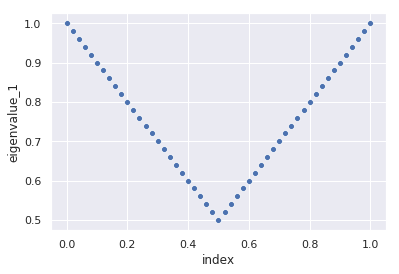

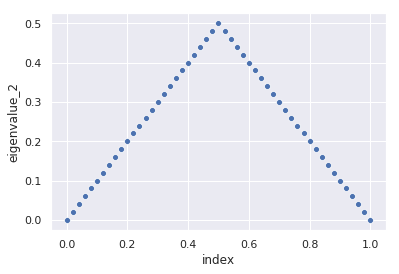

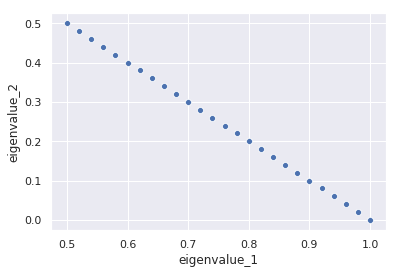

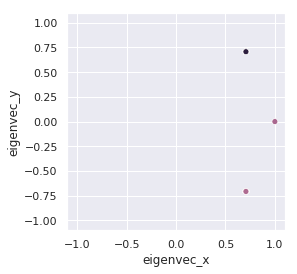

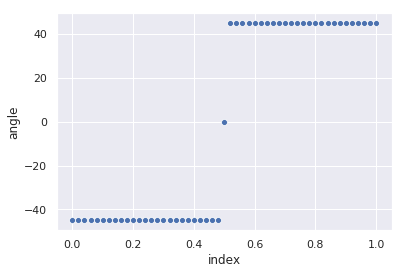

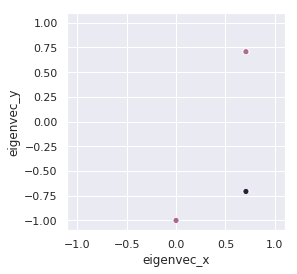

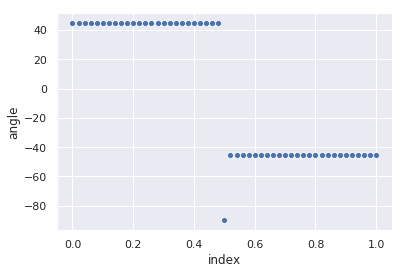

In [268]:
# Matrix path between two balanced matrices with different element signs.
matrices = matrix_interpolations(
    np.array([[1/2,-1/2], [-1/2,1/2]]),
    np.array([[1/2,1/2], [1/2,1/2]]),
)

eigen_path = EigenPath(matrices)
eigen_path.compute_eigen()
eigen_path.plot_eigenvals()
eigen_path.plot_eigenvecs()

All eigenvalues are real


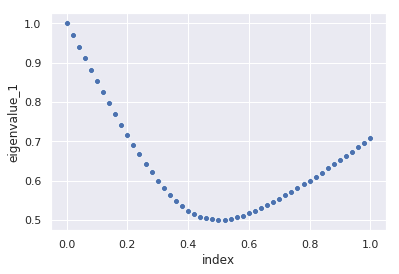

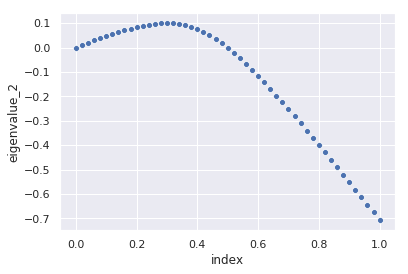

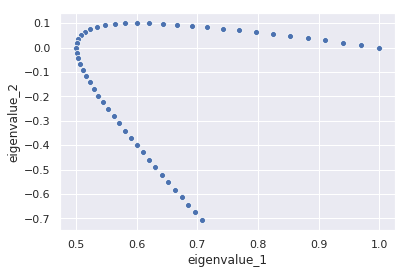

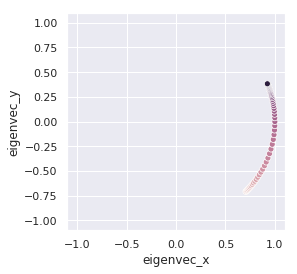

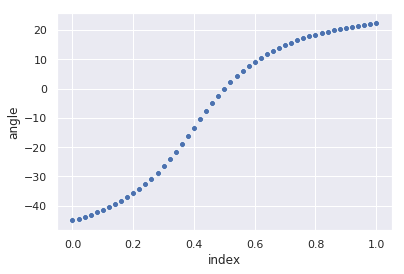

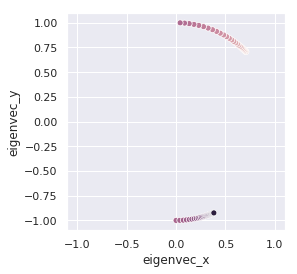

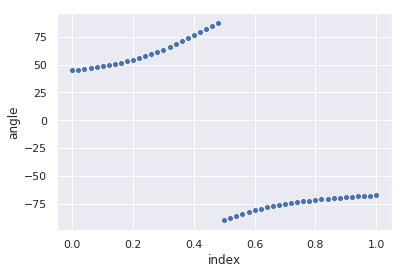

In [269]:
# Trace path between two balanced matrices with different element signs.
matrices = matrix_interpolations(
    np.array([[1/2,-1/2], [-1/2,1/2]]),
    np.array([[1/2,1/2], [1/2,-1/2]]),
    n_steps=50,
#    normalize=True
)

eigen_path = EigenPath(matrices)
eigen_path.compute_eigen()
eigen_path.plot_eigenvals()
eigen_path.plot_eigenvecs()